# 1. Object recognition and dimension application

Link to the video - https://drive.google.com/file/d/1o8FeuTMsEp8EE-ZW1pAMSEua121VbT69/view?usp=share_link

In [3]:
#!/usr/bin/env python3

from pathlib import Path
import sys
import cv2
import depthai as dai
import numpy as np
import time


model_blob_path = 'yolo-v4-tiny-tf_openvino_2021.4_6shave.blob'
# Tiny yolo v4 label texts
labelMap = [
    "person",         "bicycle",    "car",           "motorbike",     "aeroplane",   "bus",           "train",
    "truck",          "boat",       "traffic light", "fire hydrant",  "stop sign",   "parking meter", "bench",
    "bird",           "cat",        "dog",           "horse",         "sheep",       "cow",           "elephant",
    "bear",           "zebra",      "giraffe",       "backpack",      "umbrella",    "handbag",       "tie",
    "suitcase",       "frisbee",    "skis",          "snowboard",     "sports ball", "kite",          "baseball bat",
    "baseball glove", "skateboard", "surfboard",     "tennis racket", "bottle",      "wine glass",    "cup",
    "fork",           "knife",      "spoon",         "bowl",          "banana",      "apple",         "sandwich",
    "orange",         "broccoli",   "carrot",        "hot dog",       "pizza",       "donut",         "cake",
    "chair",          "sofa",       "pottedplant",   "bed",           "diningtable", "toilet",        "tvmonitor",
    "laptop",         "mouse",      "remote",        "keyboard",      "cell phone",  "microwave",     "oven",
    "toaster",        "sink",       "refrigerator",  "book",          "clock",       "vase",          "scissors",
    "teddy bear",     "hair drier", "toothbrush"
]

syncNN = True

# Create pipeline
pipeline = dai.Pipeline()

# Define sources and outputs
camRgb = pipeline.create(dai.node.ColorCamera)
spatialDetectionNetwork = pipeline.create(dai.node.YoloSpatialDetectionNetwork)
monoLeft = pipeline.create(dai.node.MonoCamera)
monoRight = pipeline.create(dai.node.MonoCamera)
stereo = pipeline.create(dai.node.StereoDepth)

xoutRgb = pipeline.create(dai.node.XLinkOut)
xoutNN = pipeline.create(dai.node.XLinkOut)
xoutBoundingBoxDepthMapping = pipeline.create(dai.node.XLinkOut)
xoutDepth = pipeline.create(dai.node.XLinkOut)

xoutRgb.setStreamName("rgb")
xoutNN.setStreamName("detections")
xoutBoundingBoxDepthMapping.setStreamName("boundingBoxDepthMapping")
xoutDepth.setStreamName("depth")

# Properties
camRgb.setPreviewSize(416, 416)
camRgb.setResolution(dai.ColorCameraProperties.SensorResolution.THE_1080_P)
camRgb.setInterleaved(False)
camRgb.setColorOrder(dai.ColorCameraProperties.ColorOrder.BGR)

monoLeft.setResolution(dai.MonoCameraProperties.SensorResolution.THE_400_P)
monoLeft.setBoardSocket(dai.CameraBoardSocket.LEFT)
monoRight.setResolution(dai.MonoCameraProperties.SensorResolution.THE_400_P)
monoRight.setBoardSocket(dai.CameraBoardSocket.RIGHT)

# setting node configs
stereo.setDefaultProfilePreset(dai.node.StereoDepth.PresetMode.HIGH_DENSITY)

spatialDetectionNetwork.setBlobPath(model_blob_path)
spatialDetectionNetwork.setConfidenceThreshold(0.5)
spatialDetectionNetwork.input.setBlocking(False)
spatialDetectionNetwork.setBoundingBoxScaleFactor(0.5)
spatialDetectionNetwork.setDepthLowerThreshold(100)
spatialDetectionNetwork.setDepthUpperThreshold(5000)

# Yolo specific parameters
spatialDetectionNetwork.setNumClasses(80)
spatialDetectionNetwork.setCoordinateSize(4)
spatialDetectionNetwork.setAnchors(np.array([10,14, 23,27, 37,58, 81,82, 135,169, 344,319]))
spatialDetectionNetwork.setAnchorMasks({ "side26": np.array([1,2,3]), "side13": np.array([3,4,5]) })
spatialDetectionNetwork.setIouThreshold(0.5)

# Linking
monoLeft.out.link(stereo.left)
monoRight.out.link(stereo.right)

camRgb.preview.link(spatialDetectionNetwork.input)
if syncNN:
    spatialDetectionNetwork.passthrough.link(xoutRgb.input)
else:
    camRgb.preview.link(xoutRgb.input)

spatialDetectionNetwork.out.link(xoutNN.input)
spatialDetectionNetwork.boundingBoxMapping.link(xoutBoundingBoxDepthMapping.input)

stereo.depth.link(spatialDetectionNetwork.inputDepth)
spatialDetectionNetwork.passthroughDepth.link(xoutDepth.input)

# Connect to device and start pipeline
with dai.Device(pipeline, True) as device:

    # Output queues will be used to get the rgb frames and nn data from the outputs defined above
    previewQueue = device.getOutputQueue(name="rgb", maxSize=4, blocking=False)
    detectionNNQueue = device.getOutputQueue(name="detections", maxSize=4, blocking=False)
    xoutBoundingBoxDepthMappingQueue = device.getOutputQueue(name="boundingBoxDepthMapping", maxSize=4, blocking=False)
    depthQueue = device.getOutputQueue(name="depth", maxSize=4, blocking=False)

    startTime = time.monotonic()
    counter = 0
    fps = 0
    color = (255, 255, 255)

    while True:
        inPreview = previewQueue.get()
        inDet = detectionNNQueue.get()
        depth = depthQueue.get()

        frame = inPreview.getCvFrame()
        depthFrame = depth.getFrame()
        depthFrameColor = cv2.normalize(depthFrame, None, 255, 0, cv2.NORM_INF, cv2.CV_8UC1)
        depthFrameColor = cv2.equalizeHist(depthFrameColor)
        depthFrameColor = cv2.applyColorMap(depthFrameColor, cv2.COLORMAP_HOT)

        counter+=1
        current_time = time.monotonic()
        if (current_time - startTime) > 1 :
            fps = counter / (current_time - startTime)
            counter = 0
            startTime = current_time

        detections = inDet.detections
        if len(detections) != 0:
            boundingBoxMapping = xoutBoundingBoxDepthMappingQueue.get()
            roiDatas = boundingBoxMapping.getConfigData()

            for roiData in roiDatas:
                roi = roiData.roi
                roi = roi.denormalize(depthFrameColor.shape[1], depthFrameColor.shape[0])
                topLeft = roi.topLeft()
                bottomRight = roi.bottomRight()
                xmin = int(topLeft.x)
                ymin = int(topLeft.y)
                xmax = int(bottomRight.x)
                ymax = int(bottomRight.y)

                cv2.rectangle(depthFrameColor, (xmin, ymin), (xmax, ymax), color, cv2.FONT_HERSHEY_SCRIPT_SIMPLEX)


        # If the frame is available, draw bounding boxes on it and show the frame
        height = frame.shape[0]
        width  = frame.shape[1]
        for detection in detections:
            # Denormalize bounding box
            x1 = int(detection.xmin * width)
            x2 = int(detection.xmax * width)
            y1 = int(detection.ymin * height)
            y2 = int(detection.ymax * height)
            try:
                label = labelMap[detection.label]
            except:
                label = detection.label
            cv2.putText(frame, str(label), (x1 + 10, y1 + 20), cv2.FONT_HERSHEY_TRIPLEX, 0.5, 255)
            cv2.putText(frame, "{:.2f}".format(detection.confidence*100), (x1 + 10, y1 + 35), cv2.FONT_HERSHEY_TRIPLEX, 0.5, 255)
            cv2.putText(frame, f"X: {int(detection.spatialCoordinates.x)} mm", (x1 + 10, y1 + 50), cv2.FONT_HERSHEY_TRIPLEX, 0.5, 255)
            cv2.putText(frame, f"Y: {int(detection.spatialCoordinates.y)} mm", (x1 + 10, y1 + 65), cv2.FONT_HERSHEY_TRIPLEX, 0.5, 255)
            cv2.putText(frame, f"Z: {int(detection.spatialCoordinates.z)} mm", (x1 + 10, y1 + 80), cv2.FONT_HERSHEY_TRIPLEX, 0.5, 255)

            cv2.rectangle(frame, (x1, y1), (x2, y2), color, cv2.FONT_HERSHEY_SIMPLEX)

        cv2.putText(frame, "NN fps: {:.2f}".format(fps), (2, frame.shape[0] - 4), cv2.FONT_HERSHEY_TRIPLEX, 0.4, color)
        cv2.imshow("depth", depthFrameColor)
        cv2.imshow("rgb", frame)

        if cv2.waitKey(1) == ord('q'):
            break

Output of the object detection- 


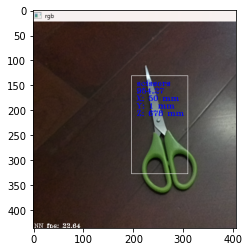

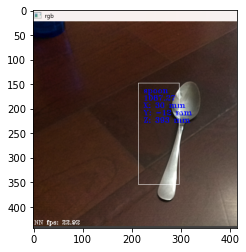

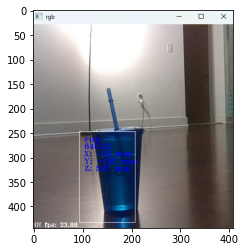

In [1]:
import matplotlib.pyplot as plt
import cv2

print("Output of the object detection- ")

plt.imshow(cv2.imread("od_1.png")[:,:,::-1])
plt.show()
plt.imshow(cv2.imread("od_2.png")[:,:,::-1])
plt.show()
plt.imshow(cv2.imread("od_3.png")[:,:,::-1])
plt.show()

# 2. Business card

Link to the video - https://drive.google.com/file/d/12EwYIrynvKeFAN6-emc5GTOiJbEwa3AO/view?usp=share_link

Designed Business Card - 


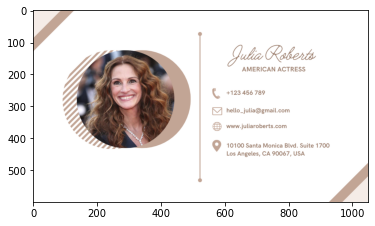

<Figure size 5760x432 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
import cv2

print("Designed Business Card - ")

plt.imshow(cv2.imread("business_card.png")[:,:,::-1])
plt.figure(figsize = (80,6))
plt.show()


### Performed face detection on the business card

In [1]:
#!/usr/bin/env python3

import cv2
import depthai as dai

# Create pipeline
pipeline = dai.Pipeline()

# Define source and output
camRgb = pipeline.create(dai.node.ColorCamera)
xoutVideo = pipeline.create(dai.node.XLinkOut)

xoutVideo.setStreamName("video")

# Properties
camRgb.setBoardSocket(dai.CameraBoardSocket.RGB)
camRgb.setResolution(dai.ColorCameraProperties.SensorResolution.THE_1080_P)
camRgb.setVideoSize(1920, 1080)

xoutVideo.input.setBlocking(False)
xoutVideo.input.setQueueSize(1)

# Linking
camRgb.video.link(xoutVideo.input)

faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Connect to device and start pipeline
with dai.Device(pipeline, True) as device:

    video = device.getOutputQueue(name="video", maxSize=1, blocking=False)

    while True:
        videoIn = video.get()

        # Get BGR frame from NV12 encoded video frame to show with opencv
        # Visualizing the frame on slower hosts might have overhead
        
        #inPreview = previewQueue.get()
        #inDet = detectionNNQueue.get()
        #depth = depthQueue.get()

        img = videoIn.getCvFrame()

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = faceCascade.detectMultiScale(gray,scaleFactor=1.2,minNeighbors=5,minSize=(20, 20))

        #print(len(faces))

        c = 0

        for (x,y,w,h) in faces:
            c += 1
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
            cv2.putText(img, 'Face', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]


        cv2.imshow('video',img) 

        k = cv2.waitKey(30) & 0xff
        if k == 27: # press 'ESC' to quit
            break

Output screenshot- 


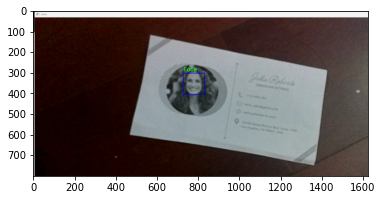

<Figure size 5760x432 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
import cv2

print("Output screenshot- ")

plt.imshow(cv2.imread("businessCard_detection.png")[:,:,::-1])
plt.figure(figsize = (80,6))
plt.show()